In [1]:
import tensorpack as tp
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt

from helpers.rsr_run import Model
from helpers.rsr_run import create_dataflow
from helpers.rsr_run import net_fn_map
from helpers.rsr2015 import *
from tensorpack import *
from tensorpack.utils.gpu import get_nr_gpu
from tensorpack.tfutils.varmanip import *
import os
from datetime import datetime

%load_ext autoreload
%autoreload 1

def avg(w): return sum(w.flatten())/len(w.flatten())

def compute_nbits_for_maxval(inp, overflow_rate):
    sorted_vals = np.sort(np.abs(inp).flatten())[::-1]
    split_idx = int(overflow_rate * len(sorted_vals))
    v = sorted_vals[split_idx]
    return math.ceil(math.log(v+1e-12, 2))

def linear_quantize(v, w_bits, bits_per_delta):
    bound = math.pow(2.0, w_bits-1)
    min_val, max_val = - bound, bound - 1
    delta = math.pow(2.0, bits_per_delta)
    quantized = np.round(v / delta)
    clipped = np.clip(quantized, min_val, max_val)
    return clipped*delta

def quantize_var(v, n_bits, overflow_rate=0.01, bits_per_delta=None):
    # +1 bc we get extra bit by taking abs val and seperating pos/neg
    if not bits_per_delta:
        bits_per_delta = compute_nbits_for_maxval(v, overflow_rate) + 1. - n_bits
    return linear_quantize(v, n_bits, bits_per_delta), bits_per_delta

def get_new_var_dict(var_dict, w_bits=32, a_bits=32, bn_bits=32, bias_bits=32, overflow_rate=0.01):
    new_var_dict = {}
    ema_stats = set(); bn_vars = set(); kernel_vars = set(); bias_vars = set()
    bits_per_delta_mapping = {}
    
    for var in var_dict:
        if 'Adam' in var or 'global_step' == var:
            new_var_dict[var] = var_dict[var]
            continue
        elif 'bits_for_maxval_var' in var:
            bits_per_delta_mapping[var] = var_dict[var] + 1. - a_bits
            new_var_dict[var] = var_dict[var]
        elif var.startswith('beta') and var.endswith('_power'):
            new_var_dict[var] = var_dict[var]
            continue
        elif var.startswith('EMA/'):
            new_var_dict[var] = var_dict[var]
            ema_stats.add(var);
        elif '/bn/' in var:
            bn_vars.add(var)
        elif var.endswith('/W') or var.endswith('/depthwise_weights'):
            kernel_vars.add(var)
        elif var.endswith('/b') or var.endswith('/biases'):
            bias_vars.add(var)
        elif 'bn' in var:
            assert False # should have removed bn variables in prior step
            bn_vars.add(var)
        else:
            print("Couldn't classify", var)

    for i,var in enumerate(kernel_vars):
        new_var, bits_per_delta = quantize_var(var_dict[var], w_bits, overflow_rate=overflow_rate)
        new_var_dict[var] = new_var
        bits_per_delta_mapping[var] = bits_per_delta

    for i,var in enumerate(bn_vars):
        new_var, bits_per_delta = quantize_var(var_dict[var], bn_bits, overflow_rate=overflow_rate)
        new_var_dict[var] = new_var

    for i,var in enumerate(bias_vars):
        # add in here finding of scale variables
        prefix = '/'.join(var.split('/')[:-1])
        
        for v in var_dict:
            if prefix in v and 'bits_for_maxval' in v:
                delta1 = bits_per_delta_mapping[v]
                break

        for v in var_dict:
            if prefix in v and (v.endswith('/W') or v.endswith('/depthwise_weights')):
                delta2 = bits_per_delta_mapping[v]
                break
        print("Using deltas",delta1,delta2,"for bias",var)
        # new_var_dict[var] = quantize_var(var_dict[var], bias_bits, overflow_rate=0.01, bits_per_delta=delta1+delta2)[0]
        new_var_dict[var] = quantize_var(var_dict[var], bias_bits, overflow_rate=overflow_rate)[0]
    
    return new_var_dict

def print_vars_in_ckpt(ckpt_path='/data/sls/u/meng/skanda/home/thesis/manfxpt/train_log/fcn2_bn_True_reg_False_quant/model-4684087'):
    var_dict = tp.tfutils.varmanip.load_chkpt_vars(ckpt_path)
    for var in var_dict.keys():
        if 'maxval' in var:
            print var, var_dict[var]
            
def plot_quant_hist(var_pairs, var_names):
    fig = plt.figure(1, figsize=(8,8*len(var_pairs)))
    for i, var in enumerate(var_names):
        plt.subplot(len(var_pairs)*2,2,2*i+1)
        plt.hist(var_pairs[i][0].flatten(),bins=100); plt.title(var);
        plt.grid(True)
        plt.subplot(len(var_pairs)*2,2,2*i+2)
        plt.hist(var_pairs[i][1].flatten(),bins=100); plt.title(var + '_quant');
        plt.grid(True)
    plt.show()
    plt.clf()

def plot_all_vars(kernel_vars, bn_vars, bias_vars):
    var_pairs = []
    for i,var in enumerate(kernel_vars):
        var_pairs.append((var_dict[var], new_var_dict[var]))
    plot_quant_hist(var_pairs, list(kernel_vars))

    var_pairs = []
    for i,var in enumerate(bn_vars):
        var_pairs.append((var_dict[var], new_var_dict[var]))
    plot_quant_hist(var_pairs, list(bn_vars))

    var_pairs = []
    for i,var in enumerate(bias_vars):
        var_pairs.append((var_dict[var], new_var_dict[var]))
    plot_quant_hist(var_pairs, list(bias_vars))

model_name='cnn'; bn = False; reg = False
datadir = '/data/sls/scratch/skoppula/kaldi-rsr/numpy/'
spkmap = '/data/sls/scratch/skoppula/backup-exps/rsr-experiments/create_rsr_data_cache/generator_full_dataset/spk_mappings.pickle'
ckpt_path = '/data/sls/u/meng/skanda/home/thesis/manfxpt/no_bn_models/cnn/checkpoint'
cachedir = '/data/sls/scratch/skoppula/backup-exps/rsr-experiments/create_rsr_data_cache/trn_cache/context_50frms/'
a_bits = 32; w_bits = 32; bn_bits = 32; bias_bits = 32; overflow_rate = 0.00
num_epochs_trn = 1; n_steps_per_epoch=8;
outdir=os.path.join('quantized_models', '_'.join([str(x) for x in [model_name, 'wbit',w_bits, 'abit', a_bits,'bnbit',bn_bits,'biasbit',bias_bits,'overflow',overflow_rate]]))
print("Outputting to outdir", outdir)
logger.set_logger_dir(outdir, action='k')
context=50
n_spks = get_n_spks(spkmap)

('Outputting to outdir', 'quantized_models/cnn_wbit_32_abit_32_bnbit_32_biasbit_32_overflow_0.0')
[0301 23:56:56 @logger.py:67] Existing log file 'quantized_models/cnn_wbit_32_abit_32_bnbit_32_biasbit_32_overflow_0.0/log.log' backuped to 'quantized_models/cnn_wbit_32_abit_32_bnbit_32_biasbit_32_overflow_0.0/log.log.0301-235656'
[0301 23:56:56 @logger.py:74] Argv: /data/sls/u/meng/skanda/home/envs/tf2cpu/lib/python2.7/site-packages/ipykernel_launcher.py -f /run/user/23571/jupyter/kernel-2a60f33c-9a36-4435-8524-75c151f6f221.json


In [2]:
var_dict = load_chkpt_vars(ckpt_path)
model = Model(n_spks, net_fn_map[model_name], bn=False, reg=False, n_context=context, qtype='linear', w_bits=w_bits, a_bits=a_bits, overflow_rate=overflow_rate)

val_dataflow, n_batches_val = create_dataflow('val', None, datadir, spkmap, None, context)
# train_dataflow, n_batches_trn = create_dataflow('train', cachedir, datadir, spkmap, None, context)
val_generator = val_dataflow.get_data()
x,y = next(val_generator)
print(x.shape, y.shape)

with TowerContext('', is_training=False):
    input = PlaceholderInput()
    input.setup(model.get_inputs_desc())
    model.build_graph(*input.get_input_tensors())
    inpx = input.get_input_tensors()[0]

    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    init = sessinit.DictRestore(var_dict)
    sess.run(tf.global_variables_initializer())
    init.init(sess)
    
    bit_maxval_tensors = [n for n in tf.get_default_graph().as_graph_def().node if n.name.endswith('bits_for_maxval')]
    tns = [tf.get_default_graph().get_tensor_by_name(n.name + ":0") for n in bit_maxval_tensors]
    update_tensors = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    for i in range(3):
        print(sess.run(tns + update_tensors, feed_dict={inpx:x})) 
    # v = [v for v in tf.global_variables() if "linear0/W" in v.name][0]; w = sess.run(v)
    
    ms = ModelSaver(checkpoint_dir=outdir)
    ms._setup_graph()
    time = datetime.now().strftime('%m%d-%H%M%S')
    ms.saver.export_meta_graph(os.path.join(ms.checkpoint_dir, 'graph-{}.meta'.format(time)), collection_list=tf.get_default_graph().get_all_collection_keys())
    ms.saver.save(sess, ms.path, global_step=0, write_meta_graph=False)

    np.savez_compressed(os.path.join(outdir, 'params.npz'), **load_chkpt_vars(os.path.join(outdir, 'checkpoint')))

('whole utterance size', 75290)
('val', False, 75288)
0
((90, 1000), (90,))
[0301 23:56:56 @registry.py:122] conv0 input: [None, 50, 20, 1]
[0301 23:56:56 @registry.py:130] conv0 output: [None, 10, 4, 6]
[0301 23:56:56 @registry.py:122] linear0 input: [None, 10, 4, 6]
[0301 23:56:56 @registry.py:130] linear0 output: [None, 256]
[0301 23:56:56 @registry.py:122] linear1 input: [None, 256]
[0301 23:56:56 @registry.py:130] linear1 output: [None, 256]
[0301 23:56:56 @registry.py:122] linear2 input: [None, 256]
[0301 23:56:56 @registry.py:130] linear2 output: [None, 256]
[0301 23:56:56 @registry.py:122] last_linear input: [None, 256]
[0301 23:56:56 @registry.py:130] last_linear output: [None, 255]
('Adding quantization bits for max val to summary:', [<tf.Tensor 'conv0/bits_for_maxval:0' shape=() dtype=float32>, <tf.Tensor 'linear0/bits_for_maxval:0' shape=() dtype=float32>, <tf.Tensor 'linear1/bits_for_maxval:0' shape=() dtype=float32>, <tf.Tensor 'linear2/bits_for_maxval:0' shape=() dtype=f

In [16]:
val_dataflow, n_batches_val = create_dataflow('val', None, datadir, spkmap, None, context)
val_generator = val_dataflow.get_data()

var_dict2 = load_chkpt_vars(os.path.join(outdir, 'checkpoint'))
var_dict = load_chkpt_vars(ckpt_path)
new_var_dict = get_new_var_dict(var_dict2, w_bits, bn_bits, bias_bits)

# on 500 val egs:
# without any substitutions:fcn2 0.780
# new_var_dict['conv0/b'] = var_dict2['conv0/b']
# new_var_dict['linear0/b'] = var_dict2['linear0/b'] # 0.746 error
# new_var_dict['linear0/W'] = var_dict2['linear0/W'] # 0.489
# new_var_dict['linear1/W'] = var_dict2['linear1/W'] # 0.0459
# new_var_dict['linear1/b'] = var_dict2['linear1/b'] # 0.0239
# new_var_dict['linear2/W'] = var_dict2['linear2/W'] # 0.02195609
# error_contribution = {'linear0/b':(0.78-0.746), 'linear0/W':(0.746-0.489), 'linear1/W':(0.489-0.0459), 'linear1/b':(0.0459-0.0239),  'linear2/W':(0.0239-0.02195), 'linear2/b':0, 'linear3/W':0,'linear3/b':0,'last_linear/W':0,'last_linear/b':0}

# without any substitutions: cnn 0.98802395
new_var_dict['conv0/b'] = var_dict2['conv0/b'] # 0.98802395
new_var_dict['conv0/W'] = var_dict2['conv0/W'] # 0.98802395
new_var_dict['linear0/b'] = var_dict2['linear0/b']  # 0.98802395
new_var_dict['linear0/W'] = var_dict2['linear0/W'] # 0.20558882
new_var_dict['linear1/b'] = var_dict2['linear1/b'] # 0.20558882
new_var_dict['linear1/W'] = var_dict2['linear1/W'] # 0.12974052
new_var_dict['linear2/b'] = var_dict2['linear2/b'] # 0.1257485
new_var_dict['linear2/W'] = var_dict2['linear2/W'] # 0.1237525
error_contribution = {'conv0/b':0,'conv0/W':0,'linear0/b':0, 'linear0/W':(0.98802-0.20558), 'linear1/W':(0.20558-0.12974), 'linear1/b':0,  'linear2/W':(0.12574-0.12375), 'linear2/b':(0.12974-0.12574), 'last_linear/W':0,'last_linear/b':0}
# 0.02195609 final error

model = Model(n_spks, net_fn_map[model_name], bn=False, reg=False, n_context=context, qtype='linear', w_bits=w_bits, a_bits=a_bits, overflow_rate=overflow_rate)
config = PredictConfig(
        model=model,
        session_init=DictRestore(new_var_dict),
        input_names=['input', 'label'],
        output_names=['utt-wrong']# ['utt-wrong']
)
predictor = OfflinePredictor(config)

rc = tp.utils.stats.RatioCounter()
for i in range(n_batches_val):
    x,y = next(val_generator)
    outputs, = predictor([x,y])
    rc.feed(outputs,1)
    if i % 100 == 0:
        print("On",i,"of",n_batches_val, "error:", rc.ratio)
    if i == 500: break
rc.ratio

('whole utterance size', 75290)
('val', False, 75288)
('Using deltas', -30.99828288704157, -37.0, 'for bias', 'linear2/b')
('Using deltas', -24.007404804229736, -32.0, 'for bias', 'conv0/b')
('Using deltas', -24.007404804229736, -25.0, 'for bias', 'last_linear/b')
('Using deltas', -25.0073184967041, -32.0, 'for bias', 'linear1/b')
('Using deltas', -24.005525588989258, -31.0, 'for bias', 'linear0/b')
('Adding quantization bits for max val to summary:', [<tf.Tensor 'conv0/bits_for_maxval:0' shape=() dtype=float32>, <tf.Tensor 'linear0/bits_for_maxval:0' shape=() dtype=float32>, <tf.Tensor 'linear1/bits_for_maxval:0' shape=() dtype=float32>, <tf.Tensor 'linear2/bits_for_maxval:0' shape=() dtype=float32>])
('Adding quantized output activations to summary:', [<tf.Tensor 'conv0/quantized_output:0' shape=(?, 10, 4, 6) dtype=float32>, <tf.Tensor 'linear0/quantized_output:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'linear1/quantized_output:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'linear2

array([0.1237525])

In [18]:
var_dict2 = load_chkpt_vars(os.path.join(outdir, 'checkpoint'))
new_var_dict = get_new_var_dict(var_dict2, w_bits, a_bits, bn_bits, bias_bits, overflow_rate)

magnitude_discrepencies_after_quantizing_from32bit_to_32bit = {}
avg_param_magnitudes_after_quantizing_from32bit_to_32bit = {}
for layer in var_dict2:
    print(layer)
    w = var_dict2[layer]
    w3 = new_var_dict[layer]
    diff = (abs(w - w3)).flatten()
    print(avg(w), avg(w3), avg(diff), max(diff), min(diff))
    if 'maxval_var' not in layer:
        magnitude_discrepencies_after_quantizing_from32bit_to_32bit[layer] = avg(diff)
        avg_param_magnitudes_after_quantizing_from32bit_to_32bit[layer] = avg(w)

('Using deltas', -30.99828288704157, -35.0, 'for bias', 'linear2/b')
('Using deltas', -24.007404804229736, -32.0, 'for bias', 'conv0/b')
('Using deltas', -24.007404804229736, -23.0, 'for bias', 'last_linear/b')
('Using deltas', -25.0073184967041, -30.0, 'for bias', 'linear1/b')
('Using deltas', -24.005525588989258, -29.0, 'for bias', 'linear0/b')
conv0/b
(28.90491498510043, 28.90491498510043, 0.0, 0.0, 0.0)
linear2/W
(-0.00017050694327355623, -0.00017050694328757388, 5.646097603123276e-13, 1.4551915e-11, 0.0)
linear0/bits_for_maxval_var
(6.994474411010742, 6.994474411010742, 0.0, 0.0, 0.0)
linear0/b
(16.32550940627698, 16.325509387999773, 4.854518920183182e-08, 4.7683716e-07, 0.0)
linear1/W
(-0.0009024414247703217, -0.0009024414242020384, 2.9873823900739005e-11, 4.656613e-10, 0.0)
conv0/bits_for_maxval_var
(6.992595195770264, 6.992595195770264, 0.0, 0.0, 0.0)
last_linear/W
(-12.958769698766577, -12.958769698747817, 2.2307230050072951e-10, 5.9604645e-08, 0.0)
linear2/b
(0.04052677856436

0.00e+00
0.00e+00
1.95e-10
4.85e-08
2.99e-11
3.49e-10
5.65e-13
8.03e-12
2.23e-10
1.46e-11


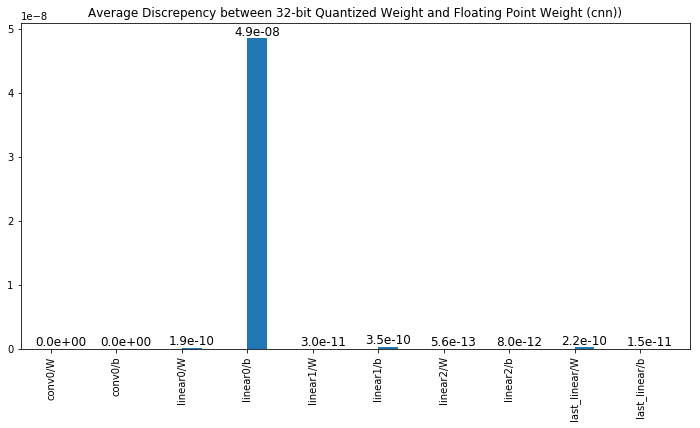

In [19]:
import matplotlib.pyplot as plt
import matplotlib

D = magnitude_discrepencies_after_quantizing_from32bit_to_32bit
plt.figure(figsize=(12, 6))

vals,keys=[],[]
for key in sorted(D):
    vals.append(D[key])
    keys.append(key)
# move last linear to back
if model_name == 'fcn2':
    vals = vals[2:] + vals[:2]
    keys = keys[2:] + keys[:2]
elif model_name == 'cnn':
    vals = vals[:2] + vals[4:] + vals[2:4]
    keys = keys[:2] + keys[4:] + keys[2:4]
    
    
bar = plt.bar(range(len(D)), vals, align='edge', width=0.3)
plt.title("Average Discrepency between 32-bit Quantized Weight and Floating Point Weight ({}))".format(model_name))
plt.xticks(range(len(D)), keys, rotation='vertical')
matplotlib.rcParams.update({'font.size': 12})
for rect in bar:
    height = rect.get_height()
    print("{:.2e}".format(height))
    plt.text(rect.get_x() + rect.get_width()/2.0, height, "{:.1e}".format(height), ha='center', va='bottom')

plt.show()
plt.savefig('discrepency_{}.png'.format(model_name))

0.00e+00
0.00e+00
7.82e+01
0.00e+00
7.58e+00
0.00e+00
1.99e-01
4.00e-01
0.00e+00
0.00e+00


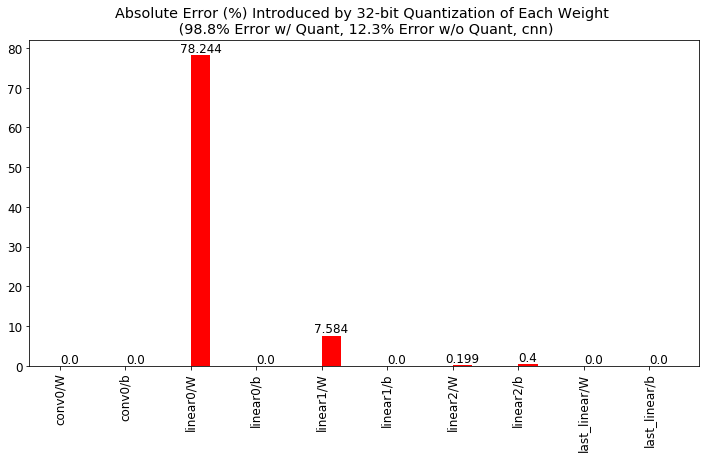

In [21]:
import matplotlib.pyplot as plt
import matplotlib

D = error_contribution
plt.figure(figsize=(12, 6))

vals,keys=[],[]
for key in sorted(D):
    vals.append(D[key])
    keys.append(key)
# move last linear to back
if model_name == 'fcn2':
    vals = vals[2:] + vals[:2]
    keys = keys[2:] + keys[:2]
elif model_name == 'cnn':
    vals = vals[:2] + vals[4:] + vals[2:4]
    keys = keys[:2] + keys[4:] + keys[2:4]
vals=[v*100 for v in vals]

bar = plt.bar(range(len(D)), vals, align='edge', width=0.3, color='red')
if model_name == 'fcn2':
    plt.title("Absolute Error (%) Introduced by 32-bit Quantization of Each Weight \n (78.0% Error w/ Quant, 2% Error w/o Quant, {})".format(model_name))
elif model_name == 'cnn':
    plt.title("Absolute Error (%) Introduced by 32-bit Quantization of Each Weight \n (98.8% Error w/ Quant, 12.3% Error w/o Quant, {})".format(model_name))
plt.xticks(range(len(D)), keys, rotation='vertical')
matplotlib.rcParams.update({'font.size': 12})
for rect in bar:
    height = rect.get_height()
    print("{:.2e}".format(height))
    plt.text(rect.get_x() + rect.get_width()/2.0, height, "{}".format(height), ha='center', va='bottom')

plt.show()
plt.savefig('errors_{}.png'.format(model_name))